In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

C:\Users\arbaa\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras import metrics
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import LeakyReLU

In [3]:
rawData = pd.read_csv('toyData.csv', sep=',')
rawData.head()

,Price,AllFuelsGen,NatGasGen,HydroGen,RenewablesGen,GDP,AvgTemp,AvgRelHum,NatGasPrice,TotElecNetGen,TotNatGasCons,TotRetailElecSales
0,11.07,14657.59,7418.12,1685.15,1689.59,1627.98,52.57,54.51,3.90,305.50,2120.20,19959.27
1,11.32,14591.10,6687.45,2515.53,1812.00,1631.46,54.04,47.27,3.79,319.94,2487.64,19863.79
2,11.17,12655.47,5888.04,1920.92,1626.95,1634.93,59.60,38.86,3.76,281.83,2242.43,17781.30
3,11.35,15788.66,7704.10,2452.48,1933.86,1638.40,55.29,51.49,3.84,302.55,2258.43,18227.13
4,10.99,13995.83,5634.56,2913.90,1895.40,1641.88,57.28,70.29,4.21,289.85,1880.99,18614.31


In [4]:
shiftMonths = 36

In [5]:
dfTargets = rawData.shift(-shiftMonths)

In [6]:
dfTargets.head()

,Price,AllFuelsGen,NatGasGen,HydroGen,RenewablesGen,GDP,AvgTemp,AvgRelHum,NatGasPrice,TotElecNetGen,TotNatGasCons,TotRetailElecSales
0,10.08,14933.67,8369.46,2274.19,1722.82,1832.79,55.31,54.01,7.49,341.95,2327.73,22930.60
1,10.85,14708.33,7131.80,2308.10,1795.28,1839.25,54.75,65.69,7.05,343.12,2561.86,20470.91
2,11.21,13294.17,6231.40,2568.14,1545.74,1845.71,53.61,74.66,7.09,298.50,2242.99,18295.03
3,10.44,15260.67,6635.72,3045.17,1927.11,1852.18,56.41,69.33,7.24,317.46,2205.79,20709.51
4,10.91,15411.81,6091.44,3500.97,1981.35,1858.64,59.46,55.26,7.79,289.56,1724.88,18656.35


In [7]:
xData = rawData.values[0:-shiftMonths]

In [8]:
print(type(xData))
print("Shape:", xData.shape)

<class 'numpy.ndarray'>
Shape: (134, 12)


In [9]:
yData = dfTargets.values[:-shiftMonths,0]

In [10]:
print(type(yData))
print("Shape:", yData.shape)

<class 'numpy.ndarray'>
Shape: (134,)


In [11]:
xTrain = xData[:(len(yData)-shiftMonths)]
xTest = xData[-shiftMonths:]
yTrain = yData[:(len(yData)-shiftMonths)]
yTest = yData[-shiftMonths:]

In [12]:
print ('Number of samples in training data:',len(xTrain))
print ('Number of samples in test data:',len(xTest))

Number of samples in training data: 98
Number of samples in test data: 36


In [13]:
xScaler = MinMaxScaler()

In [14]:
xTrainScaled = xScaler.fit_transform(xTrain)

In [15]:
print("Min:", np.min(xTrainScaled))
print("Max:", np.max(xTrainScaled))

Min: 0.0
Max: 1.0


In [16]:
xTestScaled = xScaler.transform(xTest)

In [17]:
yTrain = yTrain.reshape(-1, 1)
yTest = yTest.reshape(-1, 1)

In [18]:
yScaler = MinMaxScaler(feature_range=(2, 4))
yTrainScaled = yScaler.fit_transform(yTrain)
yTestScaled = yScaler.transform(yTest)

In [19]:
print(xTrainScaled.shape)
print(yTrainScaled.shape)

(98, 12)
(98, 1)


In [20]:
numXSignals = xData.shape[1]
numYSignals = 1

In [21]:
def batchGenerator(batchSize, sequenceLength):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        numXSignals = xData.shape[1]
        xShape = (batchSize, sequenceLength, numXSignals)
        xBatch = np.zeros(shape=xShape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        numYSignals = 1
        yShape = (batchSize, sequenceLength, numYSignals)
        yBatch = np.zeros(shape=yShape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batchSize):
            # Get a random start-index.
            # This points somewhere into the training-data.
            numTrain = len(yTrain)
            idx = np.random.randint(numTrain - sequenceLength)
            
            # Copy the sequences of data starting at this index.
            xBatch[i] = xTrainScaled[idx:idx+sequenceLength]
            yBatch[i] = yTrainScaled[idx:idx+sequenceLength]
        
        yield (xBatch, yBatch)

In [22]:
batchSize = 4
sequenceLength = 18

In [23]:
generator = batchGenerator(batchSize=batchSize,
                           sequenceLength=sequenceLength)

In [24]:
xBatch, yBatch = next(generator)

In [25]:
print(xBatch.shape)
print(yBatch.shape)

(4, 18, 12)
(4, 18, 1)


In [26]:
validationData = (np.expand_dims(xTestScaled, axis=0),
                  np.expand_dims(yTestScaled, axis=0))

In [27]:
model = Sequential()

In [28]:
model.add(GRU(units=1024, 
              activation='tanh', 
              return_sequences=True,
              input_shape=(None, numXSignals,)))

In [29]:
model.add(Dropout(0.3))

In [30]:
model.add(Dense(numYSignals, activation='relu'))
# model.add(Dense(numYSignals))

In [31]:
# model.add(LeakyReLU(alpha=.3))

In [32]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(numYSignals,
                    activation='linear',
                    kernel_initializer=init))

In [33]:
optimizer = RMSprop(lr=1e-3)

In [34]:
model.compile(loss='mae', 
              optimizer=optimizer, 
              metrics = ['mse'])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 1024)        3185664   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 1024)        0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           1025      
Total params: 3,186,689
Trainable params: 3,186,689
Non-trainable params: 0
_________________________________________________________________


In [36]:
pathCheckpoint = 'checkpoint.keras'
callbackCheckpoint = ModelCheckpoint(filepath=pathCheckpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [37]:
callbackEarlyStopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [38]:
# callback_tensorboard = TensorBoard(log_dir='./23_logs/',
#                                    histogram_freq=0,
#                                    write_graph=False)

In [39]:
callbackReduceLR = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [40]:
callbacks = [callbackEarlyStopping,
             callbackCheckpoint,
#              callback_tensorboard,
             callbackReduceLR]

In [41]:
%%time
history = model.fit_generator(generator=generator,
                              epochs=50,
                              steps_per_epoch=18,
                              validation_data=validationData,
                              callbacks=callbacks)

Epoch 1/50
17/18 [===========================>..] - ETA: 1s - loss: 2.6113 - mean_squared_error: 34.4903
Epoch 00001: val_loss improved from inf to 1.26022, saving model to checkpoint.keras
18/18 [==============================] - 28s 2s/step - loss: 2.5001 - mean_squared_error: 32.6083 - val_loss: 1.2602 - val_mean_squared_error: 1.7347
Epoch 2/50
17/18 [===========================>..] - ETA: 1s - loss: 0.6038 - mean_squared_error: 0.5517
Epoch 00002: val_loss improved from 1.26022 to 1.14535, saving model to checkpoint.keras
18/18 [==============================] - 25s 1s/step - loss: 0.5998 - mean_squared_error: 0.5431 - val_loss: 1.1453 - val_mean_squared_error: 1.4191
Epoch 3/50
17/18 [===========================>..] - ETA: 1s - loss: 0.4432 - mean_squared_error: 0.3192
Epoch 00003: val_loss improved from 1.14535 to 0.98220, saving model to checkpoint.keras
18/18 [==============================] - 25s 1s/step - loss: 0.4467 - mean_squared_error: 0.3203 - val_loss: 0.9822 - val_mea

In [42]:
try:
    model.load_weights(pathCheckpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

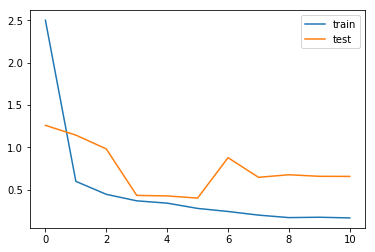

In [43]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [44]:
result = model.evaluate(x=np.expand_dims(xTestScaled, axis=0),
                        y=np.expand_dims(yTestScaled, axis=0))
print("loss (test-set):", result)

1/1 [==============================] - 0s 332ms/step
loss (test-set): [0.40235722064971924, 0.20934425294399261]


In [45]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [46]:
x1 = np.expand_dims(xTrainScaled, axis=0)
yPred1 = model.predict(x1)
yPredRescaled1 = yScaler.inverse_transform(yPred1[0])

In [47]:
x2 = np.expand_dims(xTestScaled, axis=0)
yPred2 = model.predict(x2)
yPredRescaled2 = yScaler.inverse_transform(yPred2[0])

In [48]:
t = np.arange(len(rawData['Price']) - shiftMonths)

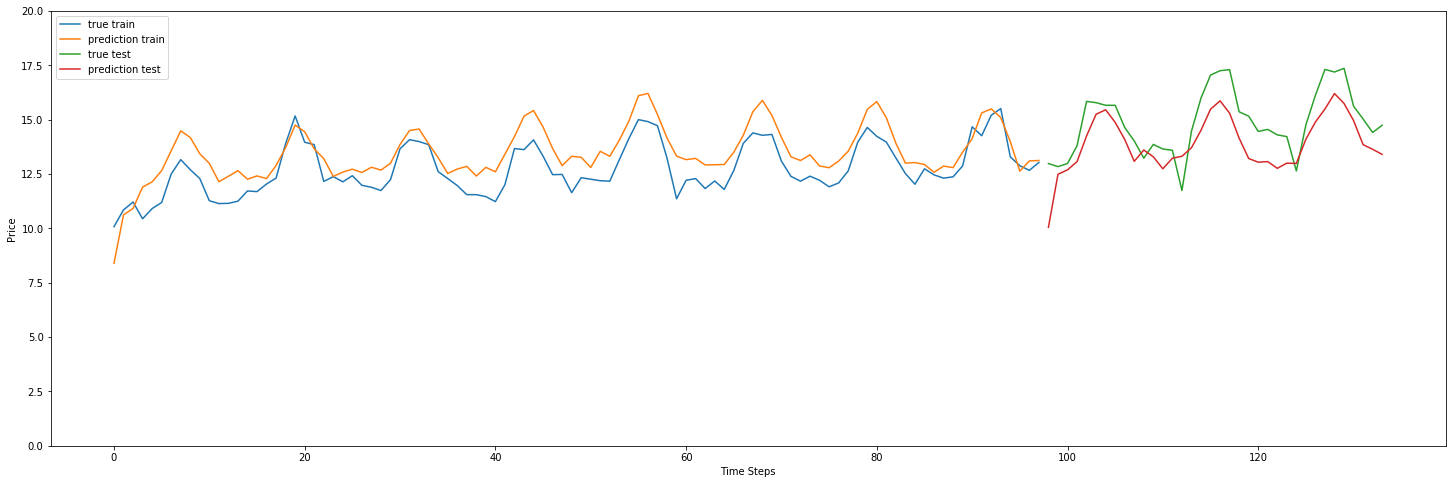

In [49]:
# Make the plotting-canvas bigger.
plt.figure(figsize=(25,8))
        
# Plot and compare the two signals.
plt.plot(t[:len(yTrain)], yTrain, label='true train')
plt.plot(t[:len(yTrain)], yPredRescaled1, label='prediction train')
plt.plot(t[len(yTrain):], yTest, label='true test')
plt.plot(t[len(yTrain):], yPredRescaled2, label='prediction test')

plt.ylim([0,20])

# Plot labels etc.
plt.xlabel('Time Steps') # in number of months
plt.ylabel('Price')
plt.legend()
plt.show()

In [50]:
np.sqrt(mean_squared_error(yTest, yPredRescaled2))

1.2422255172639836